# Wikipedia article analysis and recommendation engine

## Authors:
## Piotr Franc 160306
## Paweł Charkiewicz 160288

<hr>

## PREAMBLE
This project concerns the linguistic analysis and parsing of the Wikipedia articles. The project comprises three major parts:
1. Scrapper
2. Article processor
3. Recommendation engine

The following sections will describe each part in more detail.

#### IMPORTS
To build the scrapper we used requests, re and bs4. For database interaction we used pymongo. Text processing was achieved with bs4 and nltk. Recommendation engine's heart is powered by scipy and numpy. Network visualisation was done in graph-tool.

<hr>

### SCRAPPER
We used a breadth first search type crawler that starts with a seeding Wikipedia article or articles and proceeds to extract hyperlinks to other articles from it according to regex rules. The raw HTML of the articles is extracted first and stored in a MongoDB database for later processing. The links for investigation are stored in a separate collection. Initially, we opted for 1000 articles, as provided in the requirement. However, the architecture allows for painless scaling, so we opted for twice the initial amount.

The amount of explorable links in the database dwarfs the actual ones that were processed, at a ratio of over 273 to 2. This is because a single article can point to as many as a few hundred other articles, which satiates the crawler's need in just a few iterations. We decided to still pull new links regardless of the amount present in the db as there was little benefit to do so.

For keeping track of the origin of the crawler's pathing, each article's document in the database also contains the array of articles referencing it.

The scrapper goes to sleep for a random time interval between 5 and 8 seconds after fetching an article in order to respect the robots.txt crawl delay of Wikipedia.


<hr>

### ARTICLE PROCESSOR
With the articles stored in raw HTML form the article processor curates them offline with the MongoDB database. The heart of the script is the ```curate_content()``` function. The article is first turned into a workable form by bs4. Then, all the reference tags are decomposed and the text from the paragraphs residing in the mm-content-text div is cleaned from extra spaces and turned into a long string. This string is then lowered, tokenized and cleand of stopwords. Lastly, using the perceptron tagger the tokens are tagged and put through the WordNet lemmatizer. The result is then uploaded into a separate collection.


<hr>

### RECOMMENDATION ENGINE
Having curated articles in the database and the user's query in the form of a list of read articles a list of recommended articles for the user can be derived based on the similarity level. Having extracted curated data for the query articles and the db articles the engine computes matrices for both, which are then put through the cosine similarity function. Similarities of articles above 0.995 are discarded and turned zero, as it's extremely improbable for two distinct articles to share such high similarity level (it's almost certain the score is caused by a duplicate or exact reference to query). Then, the maximum of each column is taken, as the user's interest is not article-independent, in other words we treat the entire query as one "interest object". Lastly, the engine sorts the similarities and yields top n similarities (we chose 5 for readability).

In [28]:
class ReferredLink:
    def __init__(self, link, referrals):
        self.link = link
        self.referrals = referrals

    def __hash__(self):
        return hash(self.link)

    def __eq__(self, other):
        if isinstance(other, ReferredLink):
            return self.link == other.link
        return False

    def __repr__(self):
        return f"ReferredLink({self.link!r}, {self.referrals!r})"


In [41]:
from pymongo import MongoClient

class ArticleRepository:
    def __init__(self, client):
        db = client['articles']
        self.stored_articles_collection = db['stored_articles']
        self.explorable_links_collection = db['explorable_links']
        self.curated_articles_collection = db['curated_articles']

    def stored_links(self):
        return set(ReferredLink(article['link'], article['referrals']) for article in self.stored_articles_collection.find({}, {'link': 1, 'referrals': 1, '_id': 0}))

    def stored_articles(self):
        return self.stored_articles_collection.find({}, {"link": 1, "content": 1, "referrals": 1, "_id": 0})

    def store_article(self, link, content, referrals):
        article = {
            'link': link,
            'content': content,
            'referrals': referrals
        }
        return self.stored_articles_collection.insert_one(article)

    def stored_curated_links(self):
        return set(article['link'] for article in self.curated_articles_collection.find({}, {'link': 1, '_id': 0}))

    def curated_articles(self, links = None):
        if links is None:
            return self.curated_articles_collection.find({}, {"link": 1, "curated_content": 1, "_id": 0})
        else:
            return self.curated_articles_collection.find({"link": {"$in": links}}, {"link": 1, "curated_content": 1, "_id": 0})
    def store_curated(self, link, curated_content):
        article = {
            'link': link,
            'curated_content' : curated_content
        }
        return self.curated_articles_collection.insert_one(article)

    def store_curated_serial(self, curated_links):
        return self.curated_articles_collection.insert_many(curated_links)

    def add_explorable_links(self, referred_links: set[ReferredLink]):
        parsed_links = [{'link': link.link, 'referrals': [link.referral]} for link in referred_links]
        return self.explorable_links_collection.insert_many(parsed_links)

    def explorable_links(self):
        return list(ReferredLink(article['link'], article['referrals']) for article in self.explorable_links_collection.find({}, {'link': 1, 'referrals': 1, '_id': 0}))

    def remove_explorable_link(self, link):
        referrals = self.explorable_links_collection.find({'link': link}, {'referrals': 1, '_id': 0})[0]['referrals']
        self.stored_articles_collection.update_one(
            {"link": link},
            {"$addToSet": {"referrals": {"$each": referrals}}}
        )
        return self.explorable_links_collection.delete_one({'link': link})

    def update_stored_referrals(self, referred_links: set[ReferredLink], referral):
        extracted = [referred_link.link for referred_link in referred_links]
        if extracted:
            return self.stored_articles_collection.update_many(
            {"link": {"$in": extracted}},
            {"$addToSet": {"referrals": referral}}
            )
        return None

    def update_explorable_referrals(self, referred_links: set[ReferredLink], referral):
        extracted = [referred_link.link for referred_link in referred_links]
        if extracted:
            return self.explorable_links_collection.update_many(
            {"link": {"$in": extracted}},
            {"$addToSet": {"referrals": referral}}
            )
        return None


### Because of the varying structure of the articles themselves and the ease of setup, we deemed MongoDB an ideal choice for our usecase.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

client = MongoClient("mongodb://localhost:27017/")
repository = ArticleRepository(client=client)
vectorizer = TfidfVectorizer(analyzer=lambda x: x)

# Preparing input list
test_links = [
    "/wiki/Blast_furnace",
    "/wiki/International_Union_of_Pure_and_Applied_Chemistry",
    "/wiki/Diamondoid",
    "/wiki/Water",
    "/wiki/BTV_(Bulgaria)"
]
test_documents = [article['curated_content'] for article in repository.curated_articles(test_links)]

# Preparing db list
curated_articles = sorted(list(repository.curated_articles(list(repository.stored_curated_links()))), key=lambda x: x['link'])
curated_links = [article['link'] for article in curated_articles]
curated_documents = [article['curated_content'] for article in curated_articles]

# Computing db and query matrices
db_matrix = vectorizer.fit_transform(curated_documents)
query_matrix = vectorizer.transform(test_documents)

# Computing similarities between matrices
similarities = cosine_similarity(query_matrix, db_matrix)

# Killer threshold to discard duplicates
similarities[similarities > 0.995] = 0

# Flatten the similarities array to 1D list by taking the max similarity of db document to any document in query
# Key assumption #1: the user is unbiased in interest levels towards documents in the query
# Key assumption #2: the user is willing to read the most familiar articles to any of the read articles
similarities = np.max(similarities, axis=0)

top_indices = np.argsort(similarities)[-5:][::-1]

print("For your query:")
for link in test_links:
    print(link)

print("We recommend:")
for idx in top_indices:
    print(f"Article {curated_links[idx]} with similarity {similarities[idx]}")

For your query:
/wiki/Blast_furnace
/wiki/International_Union_of_Pure_and_Applied_Chemistry
/wiki/Diamondoid
/wiki/Water
/wiki/BTV_(Bulgaria)
We recommend:
Article /wiki/Thermal_pollution with similarity 0.5424651874481775
Article /wiki/Chemical_nomenclature with similarity 0.4233510438528894
Article /wiki/Water_tank with similarity 0.395234232296802
Article /wiki/Wastewater with similarity 0.3894966730636111
Article /wiki/Triple_point with similarity 0.366322639083973


### We operate on an already prepared token database, so there is no text processing at this stage. All text processing happens in the article_processor.py script, which operates on the scraped articles in the database by scrapper.py. The algorithm itself produces satisfactory results, recommending top articles for the user based on their query successfully.

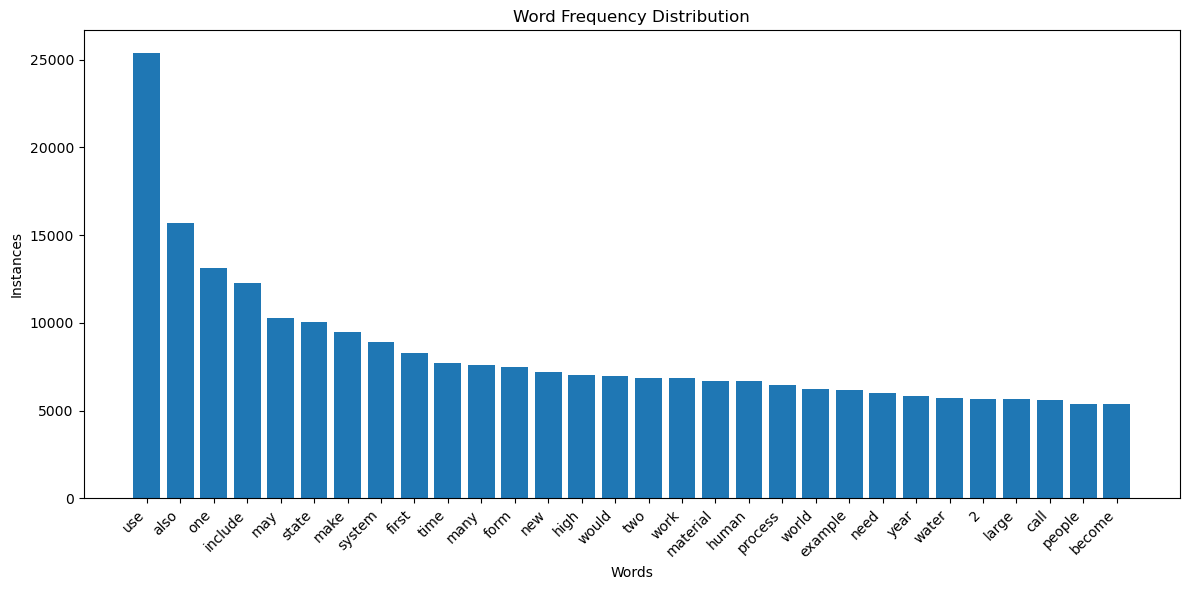

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

tokens_flat = Counter([token for document in curated_documents for token in document])

top_words = word_freq.most_common(30)

words, frequencies = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Instances')
plt.title('Word Frequency Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### With the absence of stopwords the most frequent token among all 2000 articles is "use" by a vast margin. It can be hypothesised, that since it is often truncated "used", "uses" or "usage", which are terms used in scientific descriptions and explanations, the seeding article is in STEM (which it actually is, we used Aerogel).

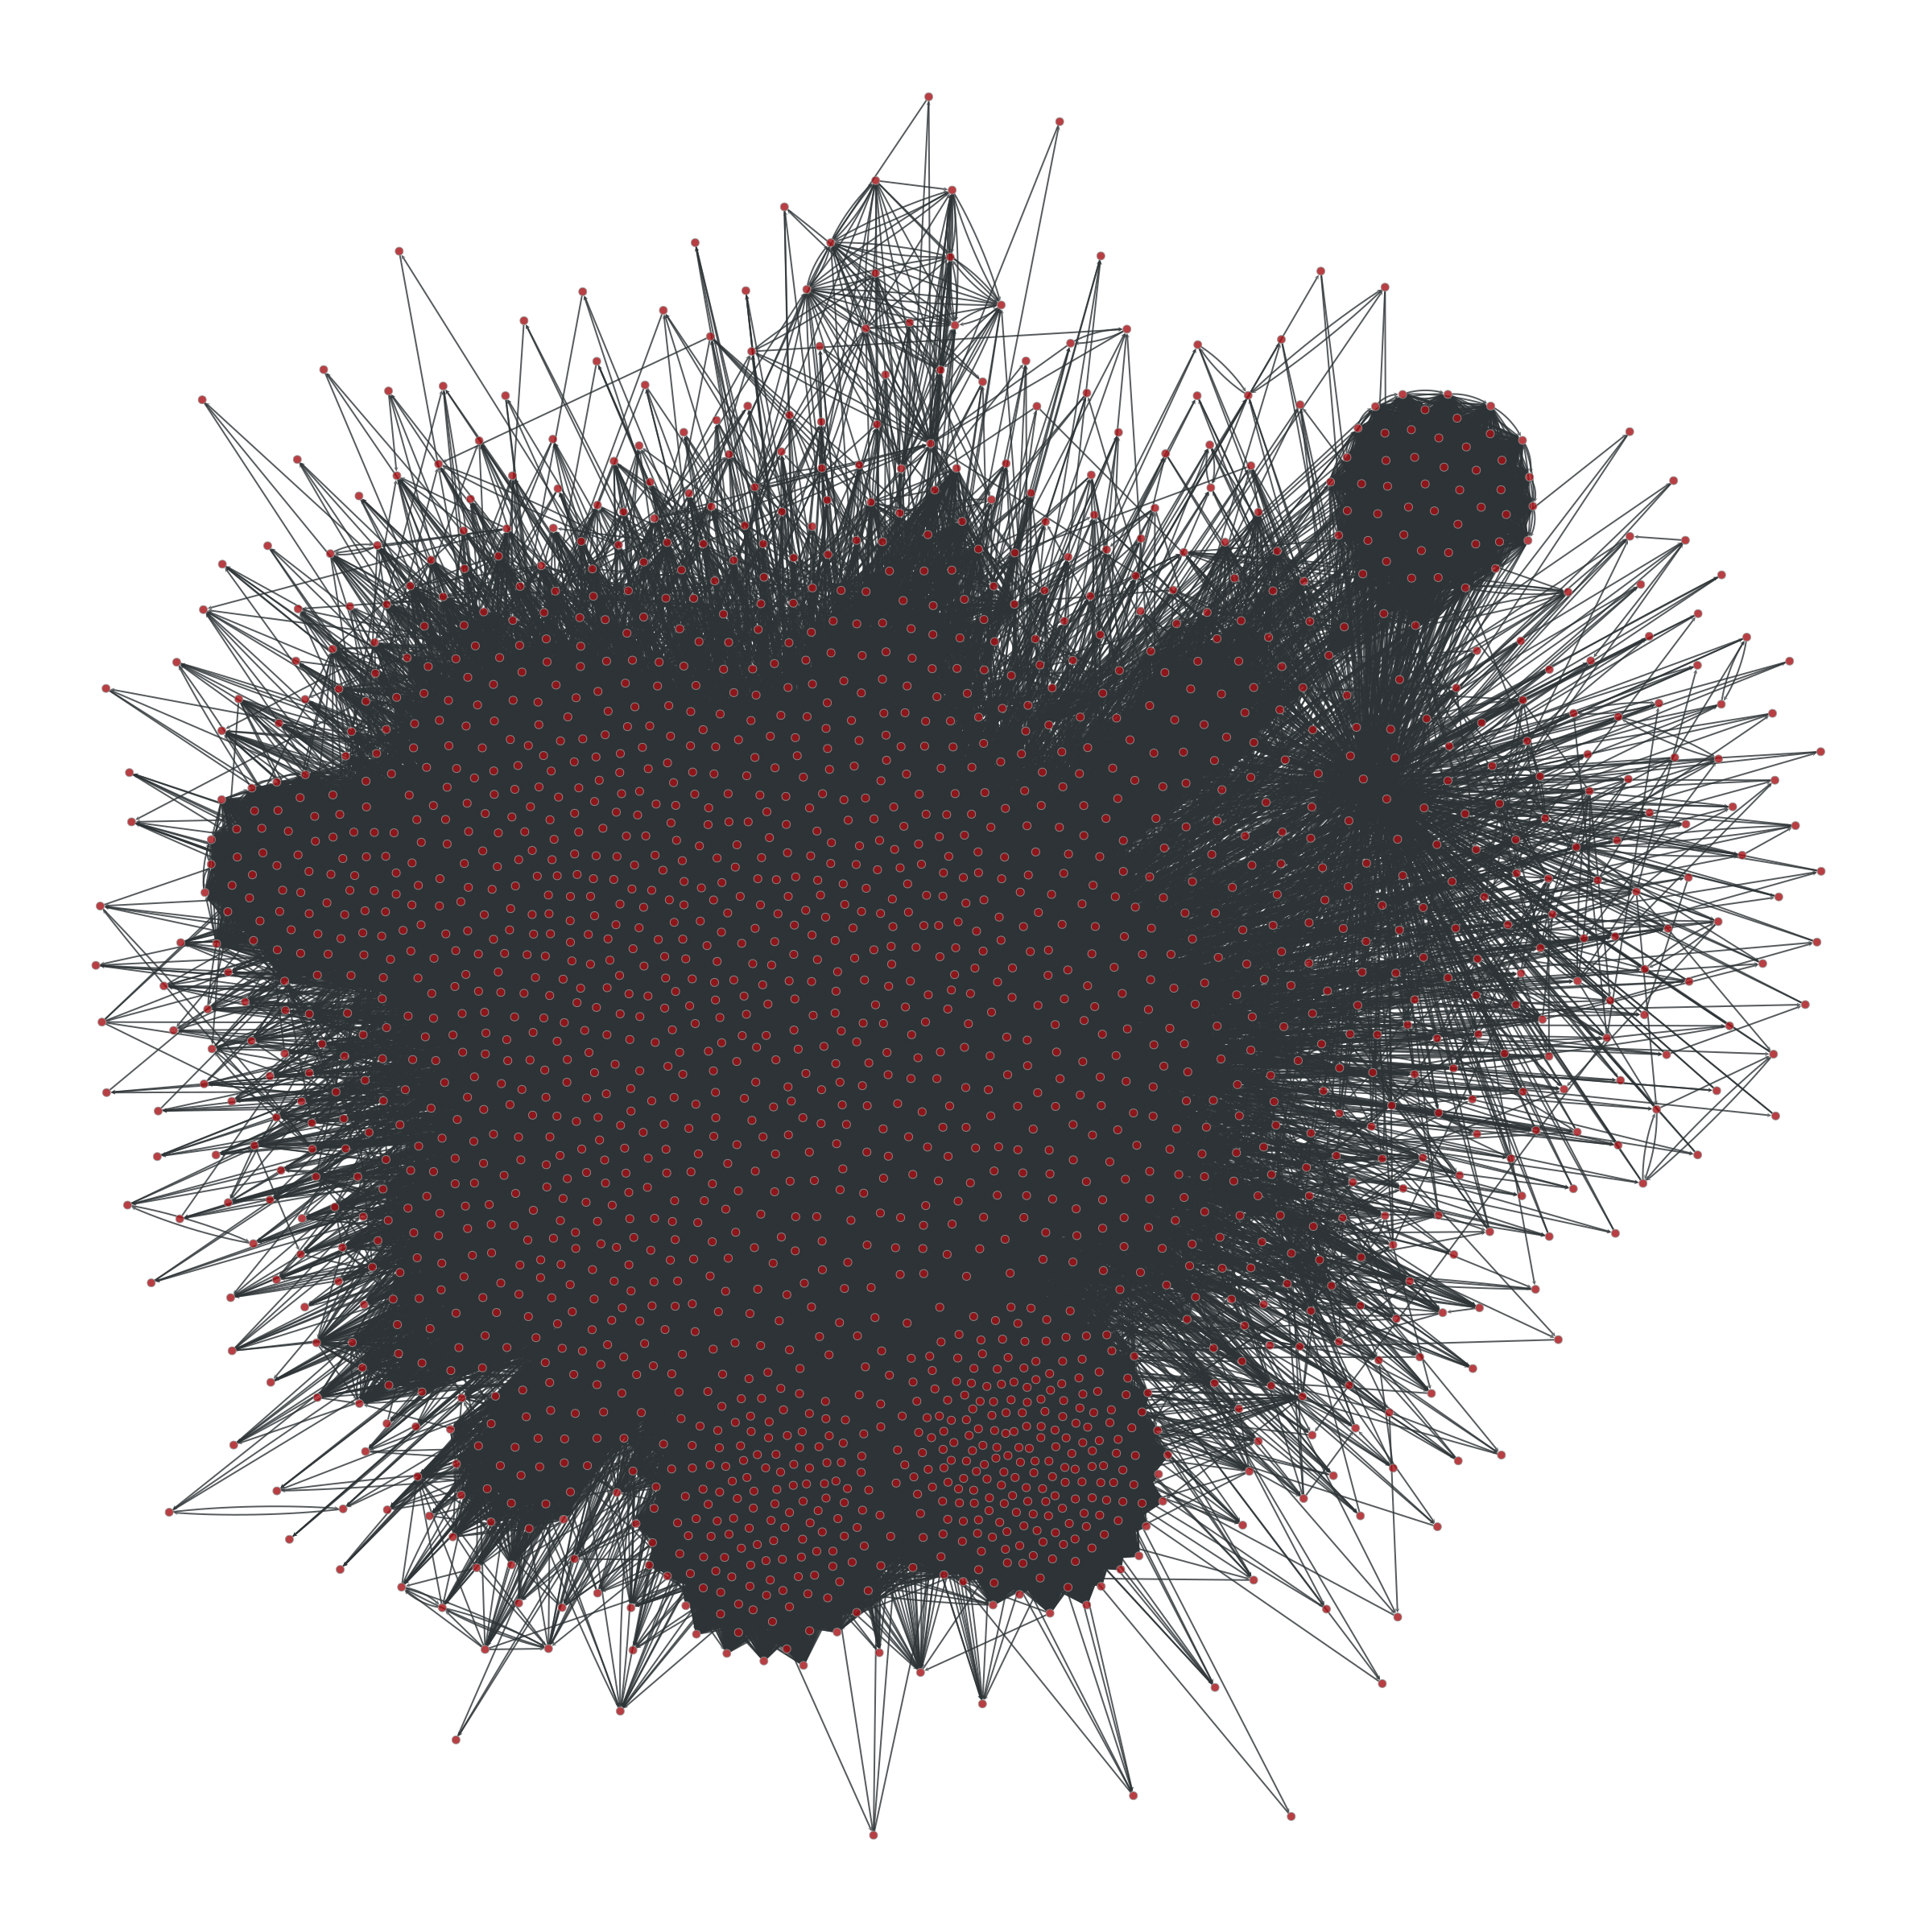

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x744e9892b800, at 0x744e982dd190>

In [34]:
from graph_tool.all import Graph, graph_draw, sfdp_layout

links_w_referrals = repository.stored_links()
g = Graph(directed=True)

edges = []
for link in links_w_referrals:
    for referral in link.referrals:
        if type(referral) is list:
            continue
        edges.append((link.link, referral))

vmap = g.add_edge_list(edges, hashed=True, hash_type="string")
g.vertex_properties["name"] = vmap

pos = sfdp_layout(g)

graph_draw(g, pos=pos, output_size=(1200, 1200), vertex_size=5, edge_pen_width=1)


### Network graph representation provides little insight. We tested different visualisations, but at the sheer volume of 2000 articles it simply becomes inoperable at those scales, requiring much smarter navigation and clever visualising techniques.

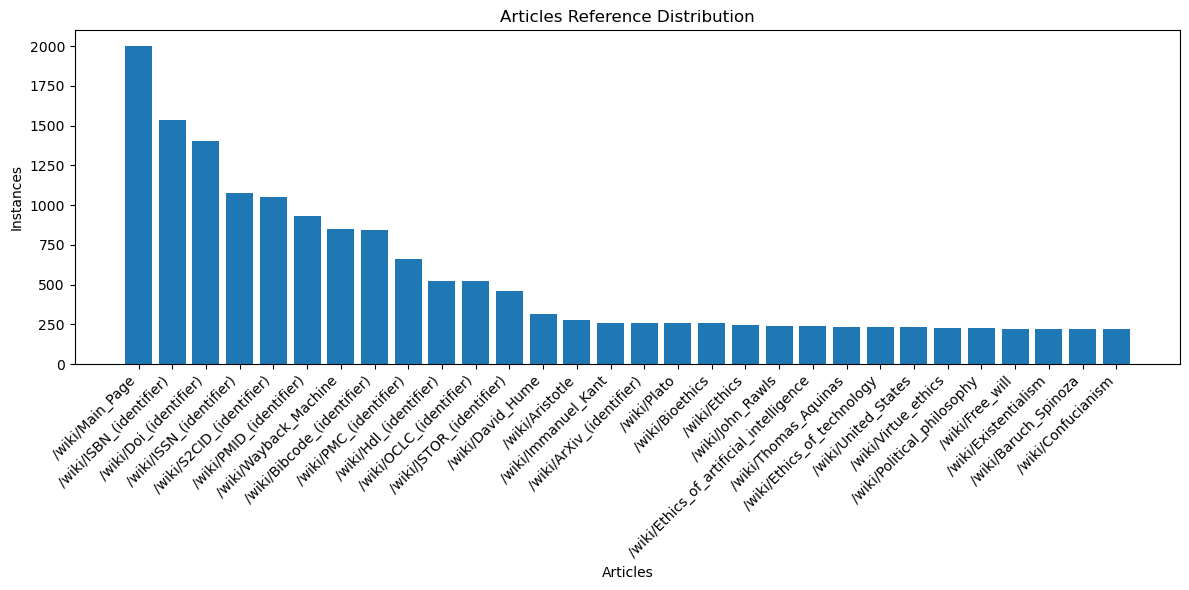

In [64]:
counted_referrals = list(client['articles']['stored_articles'].aggregate([
    {'$project': {'link' : 1, '_id': 0, 'count': {'$size': '$referrals'}}},
    {'$sort': {'count': -1}}
]))
counted_referrals = [(article['link'], article['count']) for article in counted_referrals]
top_articles = counted_referrals[:30]

articles, frequencies = zip(*top_articles)

plt.figure(figsize=(12, 6))
plt.bar(articles, frequencies)
plt.xlabel('Articles')
plt.ylabel('Instances')
plt.title('Articles Reference Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### We can, however, make conclusions by projecting the reference count onto a histogram instead. We can see that the main page is referenced on all but one articles, which is then followed by several identifiers and the Wayback Machine. From the middle till the end we see a mix of articles regarding philosophy, ethics and science, as well as a few people. We hypothesise this distribution converges the more articles we consider, although it may shift drastically **for finite sequences** should we pick a different seed.

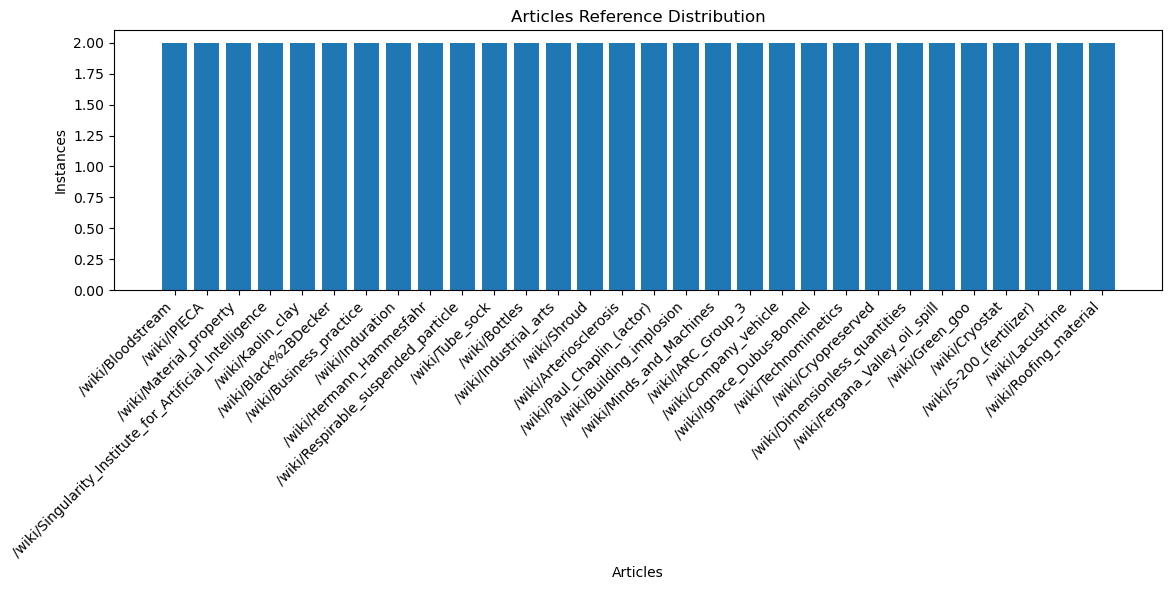

In [67]:
bottom_articles = counted_referrals[::-1][:30]

articles, frequencies = zip(*bottom_articles)

plt.figure(figsize=(12, 6))
plt.bar(articles, frequencies)
plt.xlabel('Articles')
plt.ylabel('Instances')
plt.title('Articles Reference Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Just for the sake of entertainment, we can do the same for the least referenced articles. Here we see a blend of various scientific and more accessible articles. Interestingly, none of the articles are referenced zero times. Furthermore, **all** 30 bottom articles are referenced exactly twice. Unlike the top articles, however, we hypothesise the bottom list to be much more chaotic; adding just one obscure article is enough to make an alteration.